In [1]:
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

model_id = "google/ddpm-celebahq-256"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model and scheduler
unet = UNet2DModel.from_pretrained(model_id,device=device) 



An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Simple Denoising

  0%|          | 0/50 [00:00<?, ?it/s]

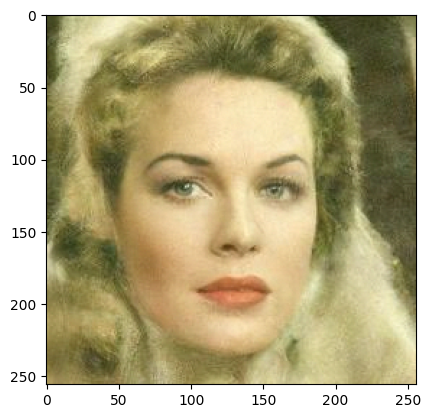

In [ ]:
torch.manual_seed(100)

unet = unet.to(device)
xt = torch.randn(1, 3, 256, 256).to(device)

scheduler = DDIMScheduler(beta_start=0.0001, beta_end=0.02, beta_schedule="linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

# sample from the model
unet.eval()

# Denoising Loop
for t in tqdm(scheduler.timesteps,total=scheduler.num_inference_steps,leave=False):
    with torch.no_grad():
        noise_pred = unet(xt,t.to(device)).sample
        
    
    xt = scheduler.step(noise_pred, t.to(device), xt).prev_sample
    

plt.imshow(xt.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.show()

# Inpainting Diffusion

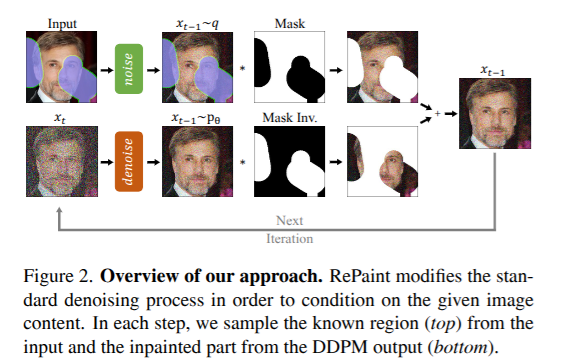
https://arxiv.org/pdf/2201.09865

## Load The Image

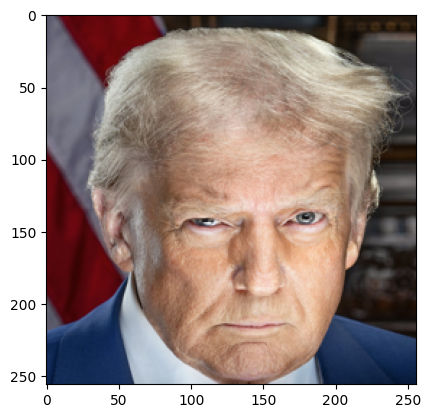

In [43]:
from PIL import Image
import numpy as np
from torchvision import transforms

transform = transforms.Compose([ transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

ref_image = Image.open('image.png').crop((300,200,2200,2300)).resize((256,256)).convert('RGB')
ref_image = transform(ref_image).unsqueeze(0).to(device)

plt.imshow(ref_image.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.show()


## Create a mask

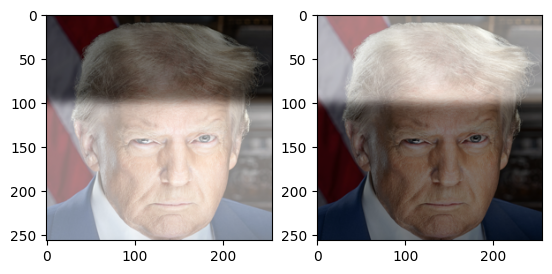

In [49]:
import numpy as np
from scipy.ndimage import gaussian_filter


mask = np.ones((256, 256), dtype=np.float32)
mask[0:100, :] = 0.0

# Apply Gaussian smoothing
mask = gaussian_filter(mask, sigma=5)
# Convert to torch tensor
mask = torch.from_numpy(mask).to(device)
# Compute inverse mask
inv_mask = 1.0 - mask

# plot the mask and inv mask
plt.subplot(1,2,1)
plt.imshow(ref_image.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.imshow(mask.squeeze().cpu().numpy(),cmap='grey',alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(ref_image.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.imshow(inv_mask.squeeze().cpu().numpy(),cmap='grey',alpha=0.5)
plt.show()

## Repaint

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009946823..0.98971945].


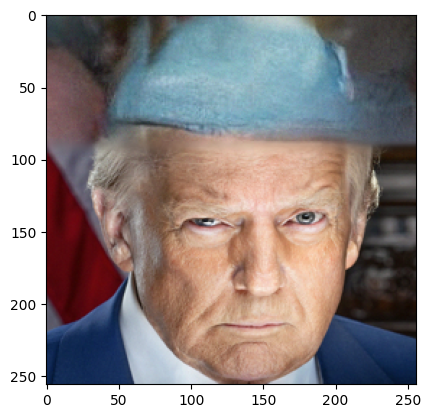

  0%|          | 0/50 [00:00<?, ?it/s]

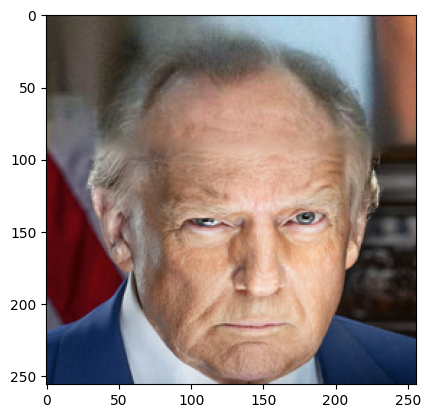

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0030118227..0.9887941].


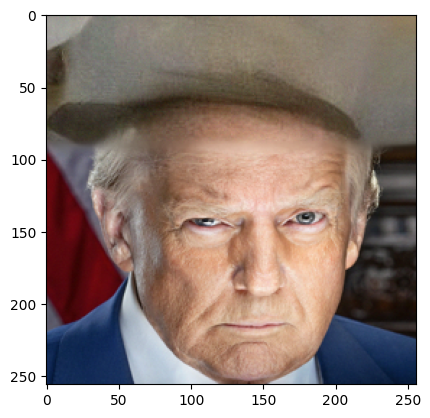

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0033521056..0.9881361].


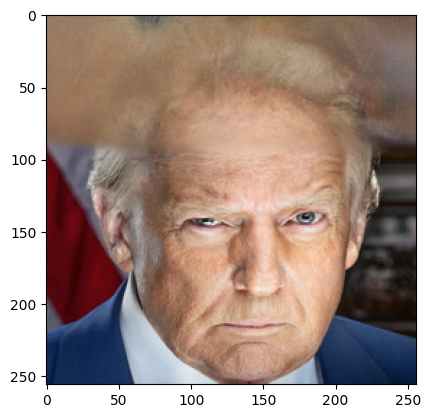

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0013161302..0.9883487].


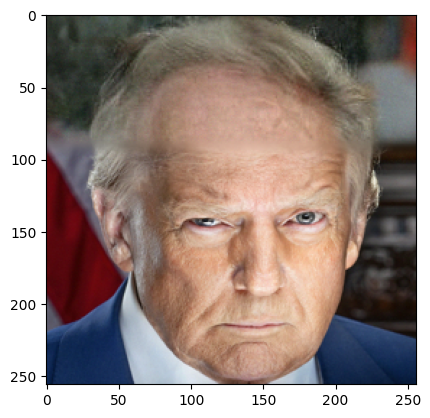

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0005597472..0.9891201].


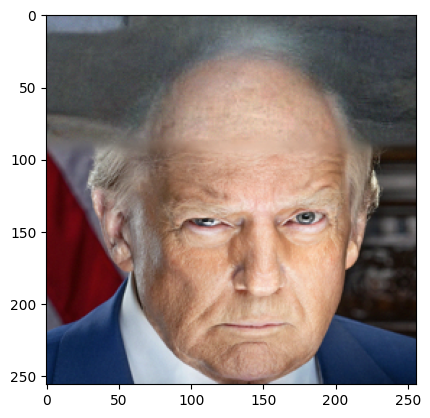

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022504926..0.98820627].


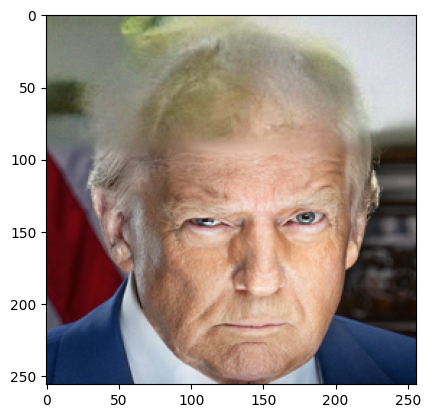

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012709498..0.9939174].


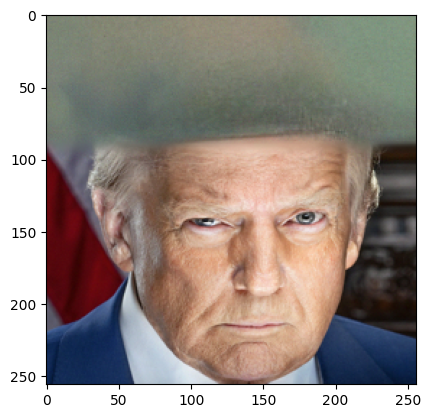

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00034350157..0.98935246].


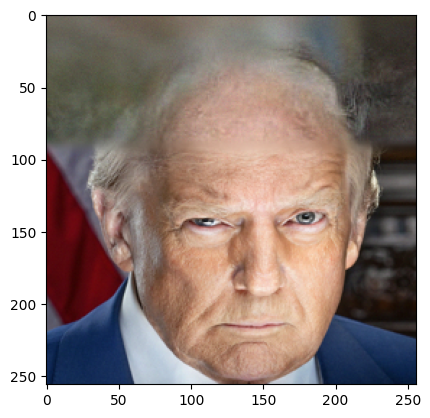

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005803168..0.9848526].


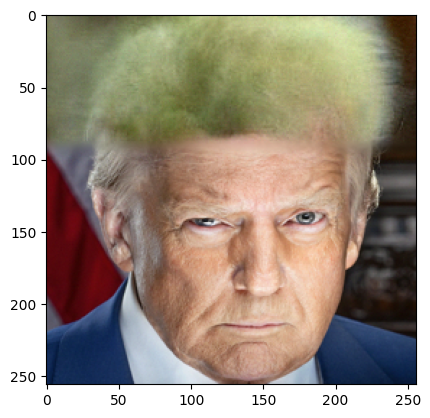

In [53]:
from IPython.display import clear_output

for seed in range(10):
    torch.manual_seed(seed)

    scheduler = DDIMScheduler(beta_start=0.0001, beta_end=0.02, beta_schedule="linear", num_train_timesteps=1000)
    scheduler.set_timesteps(50)



    # sample the random_noise
    xt = torch.randn(1, 3, 256, 256).to(device)

    # Denoising Loop
    for t in tqdm(scheduler.timesteps,total=scheduler.num_inference_steps,leave=False):
        
        # add noise to the image
        noise = torch.randn_like(ref_image).to(device)
        x_noised = scheduler.add_noise(ref_image, noise, t.to(device))
        
        
        
        with torch.no_grad():
            noise_pred = unet(xt,t.to(device)).sample
            
        
        xt = scheduler.step(noise_pred, t.to(device), xt).prev_sample
        xt = xt * inv_mask[None,None,:,:] + x_noised * mask[None,None,:,:]
        

    plt.imshow(xt.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
    # clear_output(wait=True)
    plt.show()